# Predicción de NBV 

En este notebook implementaremos un sistema para reconstrucción via NBV haciendo uso de la arquitectura autoencoder y MLP

* pedirá la dirección a la carpeta contenedora del objeto
* Creará un link simbolico para acceder a las texturas (verifica si no existe ya) y carpetas para almacenar la información obtenida durante el proceso: 
    - Nubes de puntos
    - RGB
    - Profundidad
* Despliega el objeto para verificar si es el que espera el usuario y debe confirmar si es correcto
* Genera una posición y orientación random (podría extraerla de Hintertoiser), importante conocer el bounding box para no colisionar con el objeto
* Inicia el proceso de reconstrucción
* Captura información y almacena 
* Crea grid de 31x31x31
* Procesamiento de IA
* Condición si la cumple repite o finaliza
* Reporte de métricas

## TODO: guarda y visualizar nube de puntos e imagen

In [3]:
import os
import open3d as o3d
import octomap
import torch
import numpy as np
from symlink import symbolic_dir
from utils_o3d import Get_Pointcloud, Get_RGBD, Get_octree, Get_PointcloudGT, scale_and_translate, Get_voxpoints
from MLP import MLP
from utils import net_position_nbv
from dataset_download import download_collection
from utils_metrics import chamfer_distance, Get_surface_coverage, stop_condition

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#pages is the number of objects you want to download
download_collection(owner_name="GoogleResearch", collection_name="Scanned Objects by Google Research", folder="obj", pages=2)

KeyboardInterrupt: 

In [13]:
if os.path.lexists("poses.npy") == False:
    from tesselation import hinter_sampling
    poses, _ = hinter_sampling(50, radius = 1)
    np.save("poses.npy", poses)
    print("teselando")
#print("Ingresa la dirección a la carpeta contenedora del banco de datos")
#direccion = input("Cúal es la dirección a la carpeta contenedora?:") # Dataset acces
direccion = 'objetos'
x = os.listdir(direccion)
carpeta = input("A que carpeta quieres acceder?: ") #object folder
direccion_disco = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/'
dir_carpeta = direccion_disco + direccion #+ "/" + carpeta
if os.path.lexists(dir_carpeta + "/meshes/texture.png") == False:
    symbolic_dir(dir_carpeta)
    RGB = "/RGB"
    Depth = "/Depth"
    Point_cloud = "/Point_cloud"
    Octree = "/Octree"
    os.mkdir(dir_carpeta + RGB)
    os.mkdir(dir_carpeta + Depth)
    os.mkdir(dir_carpeta + Point_cloud)
    os.mkdir(dir_carpeta + Octree)
visualizar = input("Quieres visualizar el objeto? (presiona S en caso de sí):") 
if visualizar == 'S'  or  visualizar == 's' :
    mesh = o3d.io.read_triangle_mesh(dir_carpeta + '/meshes/model.obj', True) 
    orig = o3d.geometry.TriangleMesh.create_coordinate_frame()
    o3d.visualization.draw_geometries([mesh])

img_W = 100
img_H = 100
#Cargamos los modelos de predicción de posición
model= MLP().cuda() 
path_weights = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/position/weights_entrenamiento_MLP_xavier_normal_2.pth' ## Modificar direccion de pesos
model.load_state_dict(torch.load(path_weights))
device = torch.cuda.current_device()

#Inicializamos el octomap
resolution = 0.01 # resolucion del octree
octree = octomap.OcTree(resolution) # inicializamos el octree

#Cargamos malla
mesh = o3d.io.read_triangle_mesh(dir_carpeta + '/meshes/model.obj', True)
material = o3d.visualization.rendering.MaterialRecord() # Create material
material.albedo_img = o3d.io.read_image( dir_carpeta + '/meshes/texture.png') # Add texture
mesh = scale_and_translate(mesh, scale_factor=0.39)
#Obtenemos pointcloud GT
Get_PointcloudGT(dir_carpeta, mesh)

# Raycasting
mesh1 = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(mesh1)
# render for RGBD images
render = o3d.visualization.rendering.OffscreenRenderer(width=img_W, height=img_H) #Linux only
render.scene.add_geometry('mesh', mesh, material)
#Camera vectors setup
cent = [0,0,.2]#mesh.get_center()
up = [0, 1, 0]
poses = np.load("poses.npy")
eye = [-1,-1,.5]
fov = 25
puntos = Get_voxpoints()
#occupancy_probs = np.ndarray([29791], dtype=float)
#occupancy_probs = np.full((29791), 0.5)

metricas = {"objeto": [], "chamfer": [], "distancia": [], "vistas": []}
metricas["objeto"].append(carpeta)
print("Inicia el proceso de reconstrucción ...")
#while condicion == False:
for i in range(0,15):    

    # RGBD and pointcloud extraction
    Get_Pointcloud(scene, fov, cent, eye, up, img_W, img_H, dir_carpeta, i)
    Get_RGBD(render,  fov, cent, eye, up, dir_carpeta, i)
    #Occupancy grid
    occupancy_probs =  Get_octree(octree, dir_carpeta, i, eye, puntos) #occupancy_probs)
    direccion_octree= bytes(dir_carpeta + "/Octree/octree_{}.ot".format(i), encoding='utf8')
    octree.writeBinary(direccion_octree) 
    np.save(dir_carpeta + "/Octree/grid_{}.npy".format(i),occupancy_probs, allow_pickle=True)
    ## Aqui evaluamos si esta completo el modelo en este punto
    CD = chamfer_distance(dir_carpeta)
    if i > 0:
        ind, _ = Get_surface_coverage(dir_carpeta, i)
        condicion, Distance = stop_condition(dir_carpeta,ind,i)
    else: 
        condicion = False
        Distance = 0.0
    print("Chamfer Distance: {}, Cloud distances: {}, # view: {}".format(CD, Distance, i))
    metricas["chamfer"].append(CD)
    metricas["distancia"].append(Distance)
    if condicion == True:
        break
    ## De no estarlo, se consulta a la NN el NBV 
    else:
        grid = np.reshape(occupancy_probs, (1,1,31,31,31))  
        torch_grid = torch.from_numpy(grid)
        #IA-NBV
        output = net_position_nbv(model, torch_grid, device) 
        eye = output.numpy().reshape(3,).astype("double") 
    print("nbv:", eye)

metricas["vistas"].append(i)
print(metricas)   
print("Volví, tonotos!")
#almacena las métricas de error en archivo NPZ
np.savez('metricas.npz', obj=metricas["objeto"] ,chamfer = metricas["chamfer"], distancias = metricas["distancia"], numero=metricas["vistas"])

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x164fbba0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
Inicia el proceso de reconstrucción ...
Chamfer Distance: 0.04457739928826734, Cloud distances: 0.0, # view: 0
nbv: [ 0.9966  0.9542 -0.5479]


KeyboardInterrupt: 

In [12]:
o3d.visualization.draw_geometries([mesh])

## Pruebas de MAtrices

In [1]:
import open3d as o3d
import numpy as np 
from utils_camera import save_camera_trayectory

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
eye = np.load("poses.npy")
center = [0,0,.2]#mesh.get_center()
up = [0, 1, 0]
fov = 25
width = 100
height = 100
direccion = "objetos"

In [3]:
save_camera_trayectory(direccion, eye[:10], center, up, fov, width, height)

## Pruebas ploteo trayectoria

In [3]:
import open3d as o3d
import numpy as np
#from utils_o3d import camara
from utils_visualizer import draw_camera
#param = o3d.io.read_pinhole_camera_parame]ters("viewpoint.json")
#ctr.convert_from_pinhole_camera_parameters(param)

In [4]:
param = o3d.io.read_pinhole_camera_trajectory(direccion + "/trayectoria_camara.json")

In [5]:
frames = []
scale = 1.0
color=[0.8,0.2,0.8]
for i in range (0,len(param.parameters)):
    extrinsic = param.parameters[i].extrinsic
    intrinsic = param.parameters[i].intrinsic.intrinsic_matrix
    width = param.parameters[i].intrinsic.width
    height = param.parameters[i].intrinsic.height
    camera_model = draw_camera(intrinsic, extrinsic, width, height)
    frames.extend(camera_model)
    #for i in frames:
    #    self.__vis.add_geometry(i)


In [6]:
mesh = o3d.io.read_triangle_mesh('objetos/meshes/model.obj', True) 

In [7]:
frames.append(mesh)

In [8]:
o3d.visualization.draw_geometries(frames)

## Extras

In [55]:
import open3d as o3d
import numpy as np
import octomap
import trimesh
import matplotlib.pyplot as plt
import cv2
from utils_o3d import scale_and_translate, Get_voxpoints

In [57]:
from classification_nbv import showGrid, showGrid4
import numpy as np

In [57]:
occupancy_probs = np.load('/mnt/6C24E28478939C77/Saulo/ProyectoPHD/objetos'+'/Octree/grid_6.npy')

In [58]:
model= MLP().cuda() 
path_weights = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/position/weights_entrenamiento_MLP_xavier_normal_2.pth' ## Modificar direccion de pesos
model.load_state_dict(torch.load(path_weights))
device = torch.cuda.current_device()

NameError: name 'MLP' is not defined

In [ ]:
grid = np.reshape(occupancy_probs, (1,1,31,31,31))  
torch_grid = torch.from_numpy(grid)
#IA-NBV
output = net_position_nbv(model, torch_grid, device)
output

tensor([[0.2578, 0.1544, 0.0265]])

In [ ]:
occupancy_probs1 = np.ndarray([29791], dtype=float)
print(occupancy_probs1)

[ 6.93734655e-310  6.93734655e-310  1.33201727e-315 ... -2.91976631e-002
  1.15272760e-001  5.53270578e-002]


In [ ]:
np.set_printoptions(threshold = np.inf,precision=4, suppress=True)
print(occupancy_probs)

[0.5    0.5    0.5    0.5    0.5    0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.5    0.5    0.5    0.5    0.5    0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.5    0.5    0.5    0.5    0.5    0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.5    0.5    0.5    0.5    0.5    0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.5    0.5    0.1192 0.1192 0.1192 0.1192
 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192 0.1192
 0.119

In [ ]:
showGrid(oc_prob, "1.png")

<Figure size 640x480 with 0 Axes>

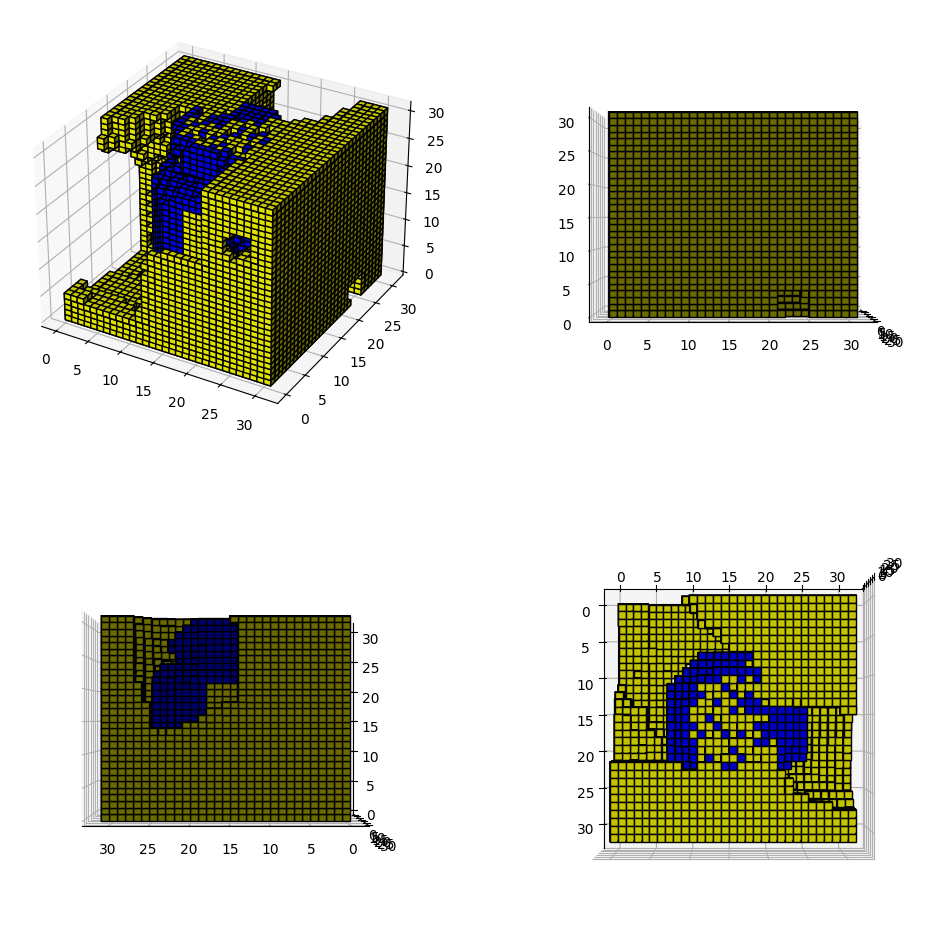

In [ ]:
showGrid4(occupancy_probs)

In [ ]:
mesh.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-0.15, -0.15, 0), max: (0.305768, 0.187835, 0.374013)

In [ ]:
del octree
del mesh
del mesh1
del material
del scene
del render

In [ ]:
del scene
del render

## Reconstrucción pato (dataset entrenamiento)

In [ ]:
mesh = o3d.io.read_triangle_mesh('duck/mesh.ply')
o3d.visualization.draw_geometries([mesh])

In [ ]:
if os.path.lexists("poses.npy") == False:
    from tesselation import hinter_sampling
    poses, _ = hinter_sampling(50, radius = 1)
    np.save("poses.npy", poses)
    print("teselando")
#print("Ingresa la dirección a la carpeta contenedora del banco de datos")
#direccion = input("Cúal es la dirección a la carpeta contenedora?:") # Dataset acces
direccion = 'duck'
x = os.listdir(direccion)
#carpeta = input("A que carpeta quieres acceder?: ") #object folder
direccion_disco = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/'
dir_carpeta = direccion_disco + direccion #+ "/" + carpeta
#symbolic_dir(dir_carpeta)
#RGB = "/RGB"
#Depth = "/Depth"
#Point_cloud = "/Point_cloud"
#Octree = "/Octree"
#os.mkdir(dir_carpeta + RGB)
#os.mkdir(dir_carpeta + Depth)
#os.mkdir(dir_carpeta + Point_cloud)
#os.mkdir(dir_carpeta + Octree)
visualizar = input("Quieres visualizar el objeto? (presiona S en caso de sí):") 
if visualizar == 'S'  or  visualizar == 's' :
    mesh = o3d.io.read_triangle_mesh(dir_carpeta + '/mesh.ply', True) 
    o3d.visualization.draw_geometries([mesh])

img_W = 100
img_H = 100
#Cargamos los modelos de predicción de posición
model= MLP().cuda() 
path_weights = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/position/weights_entrenamiento_MLP_xavier_normal_2.pth' ## Modificar direccion de pesos
model.load_state_dict(torch.load(path_weights))
device = torch.cuda.current_device()

#Inicializamos el octomap
resolution = 0.01 # resolucion del octree
octree = octomap.OcTree(resolution) # inicializamos el octree

#Cargamos malla
mesh = o3d.io.read_triangle_mesh(dir_carpeta + '/mesh.ply', True)
material = o3d.visualization.rendering.MaterialRecord() # Create material
material.albedo_img = o3d.io.read_image( dir_carpeta + '/texture.png') # Add texture
max = mesh.get_max_bound()
scale = 0.4/np.max(max)
mesh.scale(scale, center= [0,0,.2])#Scale mesh
traslacion = [-.1,-.1,0]- np.asarray(mesh.get_min_bound())
#traslacion =  [0,0,traslacion]
mesh.translate(traslacion) #translate mesh
max = mesh.get_max_bound()
scale = 0.4/np.max(max)
mesh.scale(scale, center= [0,0,.2])#Scale mesh
traslacion = [-.18,-.18,0]- np.asarray(mesh.get_min_bound())
#traslacion =  [0,0,traslacion]
mesh.translate(traslacion) #translate mesh
#Obtenemos pointcloud GT
Get_PointcloudGT(dir_carpeta, mesh)

# Raycasting
mesh1 = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(mesh1)
# render for RGBD images
render = o3d.visualization.rendering.OffscreenRenderer(width=img_W, height=img_H) #Linux only
render.scene.add_geometry('mesh', mesh, material)
#Camera vectors setup
cent = mesh.get_center()
up = [0, 1, 0]
poses = np.load("poses.npy")
eye = [-1,-1,.5]
fov = 30
puntos = Get_voxpoints()
#occupancy_probs = np.ndarray([29791], dtype=float)
#occupancy_probs = np.full((29791), 0.5)

metricas = {"objeto": [], "chamfer": [], "distancia": [], "vistas": []}
metricas["objeto"].append(direccion)
print("Inicia el proceso de reconstrucción ...")
#while condicion == False:
for i in range(0,20):    

    # RGBD and pointcloud extraction
    Get_Pointcloud(scene, fov, cent, eye, up, img_W, img_H, dir_carpeta, i)
    Get_RGBD(render,  fov, cent, eye, up, dir_carpeta, i)
    #Occupancy grid
    occupancy_probs =  Get_octree(octree, dir_carpeta, i, eye, puntos) #occupancy_probs)
    direccion_octree= bytes(dir_carpeta + "/Octree/octree_{}.ot".format(i), encoding='utf8')
    octree.writeBinary(direccion_octree) 
    np.save(dir_carpeta + "/Octree/grid_{}.npy".format(i),occupancy_probs, allow_pickle=True)
    ## Aqui evaluamos si esta completo el modelo en este punto
    CD = chamfer_distance(dir_carpeta)
    if i > 0:
        ind, _ = Get_surface_coverage(dir_carpeta, i)
        condicion, Distance = stop_condition(dir_carpeta,ind,i)
    else: 
        condicion = False
        Distance = 0.0
    print("Chamfer Distance: {}, Cloud distances: {}, # view: {}".format(CD, Distance, i))
    metricas["chamfer"].append(CD)
    metricas["distancia"].append(Distance)
    if condicion == True:
        break
    ## De no estarlo, se consulta a la NN el NBV 
    else:
        grid = np.reshape(occupancy_probs, (1,1,31,31,31))  
        torch_grid = torch.from_numpy(grid)
        #IA-NBV
        output = net_position_nbv(model, torch_grid, device) 
        eye = output.numpy().reshape(3,).astype("double") 
    print("nbv:", eye)

metricas["vistas"].append(i)
print(metricas)   
print("Volví, tonotos!")
#almacena las métricas de error en archivo NPZ
np.savez('metricas_duck.npz', obj=metricas["objeto"] ,chamfer = metricas["chamfer"], distancias = metricas["distancia"], numero=metricas["vistas"])

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x12b93940 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
Inicia el proceso de reconstrucción ...
Chamfer Distance: 0.033826832801817676, Cloud distances: 0.0, # view: 0
nbv: [ 0.99939108  0.99718255 -0.71014738]
Chamfer Distance: 0.007454197040686353, Cloud distances: 0.0, # view: 1
nbv: [0.58441937 0.30590165 0.32433018]
Chamfer Distance: 0.005934723398144237, Cloud distances: 0.027476882430647293, # view: 2
nbv: [0.98464251 0.98034227 0.22959411]
Chamfer Distance: 0.005431723415581975, Cloud distances: 0.21756290083867785, # view: 3
nbv: [0.98646641 0.97571075 0.11200407]
Chamfer Distance: 0.005210408629004677, Cloud distances: 0.04196471149260849, # view: 4
nbv: [0.98518121 0.9747448  0.12604518]
Chamfer Distance: 0.005055460261201929, Cloud distances: 0.11227902532250358, # view: 5
nbv: [0.98606181 0.97449303 0.10586746]
Chamfer Distance: 0.004932256854737469, Cloud distances: 0.04981024667931689, # view: 6
nbv: [0

KeyboardInterrupt: 

In [ ]:
mesh.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (0, 0, 0), max: (0.455768, 0.337835, 0.374013)

In [ ]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
nube = o3d.io.read_point_cloud('/mnt/6C24E28478939C77/Saulo/ProyectoPHD/obj/'+'2_of_Jenga_Classic_Game'+"/Point_cloud/cloud_0.pcd")

In [ ]:
del mesh

In [ ]:
mesh = o3d.io.read_triangle_mesh('duck/mesh.ply')

In [ ]:
mesh.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-53.3174, -41.5583, -83.2927), max: (51.1119, 35.8493, 2.40424)

In [ ]:
max = mesh.get_max_bound()
scale = 0.4/np.max(max)
mesh.scale(scale, center= [0,0,.2])#Scale mesh
traslacion = [-.1,-.1,0]- np.asarray(mesh.get_min_bound())
#traslacion =  [0,0,traslacion]
mesh.translate(traslacion) #translate mesh
max = mesh.get_max_bound()
scale = 0.4/np.max(max)
mesh.scale(scale, center= [0,0,.2])#Scale mesh
traslacion = [-.1,-.1,0]- np.asarray(mesh.get_min_bound())
#traslacion =  [0,0,traslacion]
mesh.translate(traslacion) #translate mesh
mesh.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-0.1, -0.1, 0), max: (0.355768, 0.237835, 0.374013)

In [28]:






mesh.get_max_bound()

array([51.1119 , 35.8493 ,  2.40424])

In [10]:
o3d.visualization.draw_geometries([mesh])

In [ ]:
traslacion = - np.asarray(mesh.get_min_bound())[2]
traslacion =  [0,0,traslacion]
mesh.translate(traslacion) #translate mesh
o3d.visualization.draw_geometries([mesh])

In [3]:
mesh.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-53.3174, -41.5583, -83.2927), max: (51.1119, 35.8493, 2.40424)

In [4]:
mesh.get_center()

array([  1.31834775,  -3.06894927, -27.48380708])

In [1]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
demo_crop_data = o3d.data.DemoCropPointCloud()
pcd = o3d.io.read_point_cloud(demo_crop_data.point_cloud_path)
vol = o3d.visualization.read_selection_polygon_volume(demo_crop_data.cropped_json_path)
chair = vol.crop_point_cloud(pcd)

dists = pcd.compute_point_cloud_distance(chair)
dists = np.asarray(dists)
ind = np.where(dists > 0.01)[0]
pcd_without_chair = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([pcd_without_chair],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [27]:
dists1 = pcd.compute_mahalanobis_distance()
dists1 = np.asarray(dists1)
ind1 = np.where(dists1 > 0.01)[0]
pcd_without_chair1 = pcd.select_by_index(ind1)
o3d.visualization.draw_geometries([pcd_without_chair1],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [6]:
dists1 = pcd.compute_nearest_neighbor_distance()
dists1 = np.asarray(dists1)
ind1 = np.where(dists1 > 0.004)[0]
pcd_without_chair1 = pcd.select_by_index(ind1)
o3d.visualization.draw_geometries([pcd_without_chair1],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [8]:
p_c = o3d.io.read_point_cloud("obj/2_of_Jenga_Classic_Game/Point_cloud/cloud_acc.pcd")
#o3d.visualization.draw_geometries([p_c])

In [3]:
pcd = o3d.io.read_point_cloud("obj/2_of_Jenga_Classic_Game/Point_cloud/cloud_8.pcd")

In [11]:
p_c.Type

open3d.cuda.pybind.geometry.Geometry.Type

In [5]:
size = np.asarray(mesh.vertices).shape[0]

In [6]:
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])
pcd = mesh.sample_points_uniformly(number_of_points=size*10)
o3d.visualization.draw_geometries([pcd])

In [10]:
pcd.Type

open3d.cuda.pybind.geometry.Geometry.Type

In [60]:
o3d.visualization.draw_geometries([pcd])

In [5]:
np.asarray(pcd.points).shape

(196133, 3)

In [4]:
dists.shape

(196133,)

In [7]:
len(p_c.points)

37080

In [8]:
len(pcd.points)

53230

In [52]:
dist = np.asarray(p_c.compute_point_cloud_distance(p_c))
ind = np.where(dist < 0.0037)[0]
pcd_wo = p_c.select_by_index(ind, invert=True) 
o3d.visualization.draw_geometries([pcd_wo])

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [53]:
len(pcd_wo.points)

0

In [7]:
np.savez('/kaggle/working/entrenamiento_mlp_7.npz', entrenamiento = losses["entrenamiento"], validación = losses["validación"])

In [9]:
direccion_disco = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/obj/2_of_Jenga_Classic_Game'

In [10]:
Get_cloud_distance(direccion_disco,9, umbral= 0.0037)

(False, 62.00199203187251)

In [5]:
chamfer_distance(np.asarray(p_c.points),np.asarray(pcd.points))

0.017517819506284872

In [39]:
losses = {"objeto": [], "chamfer": [], "distancia": [], "vistas": []}

In [26]:
arrays = np.zeros((15))
arrys1 = np.ones((15))
vista = 5


In [42]:
losses["objeto"].append("primero")
losses["chamfer"].append(arrays[vista*0:vista*1])
losses["distancia"].append(arrys1[vista*0:vista*1])
losses["vistas"].append(vista)

In [43]:
losses["objeto"].append("segundo")
losses["chamfer"].append(arrays[vista*1:vista*2])
losses["distancia"].append(arrys1[vista*1:vista*2])
losses["vistas"].append(vista)

In [37]:
losses.clear()

In [45]:
losses

{'objeto': ['primero', 'segundo', 'primero', 'segundo'],
 'chamfer': [array([0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0.])],
 'distancia': [array([1., 1., 1., 1., 1.]),
  array([1., 1., 1., 1., 1.]),
  array([1., 1., 1., 1., 1.]),
  array([1., 1., 1., 1., 1.])],
 'vistas': [5, 5, 5, 5]}

In [ ]:
np.savez('/kaggle/working/entrenamiento_mlp_7.npz', entrenamiento = losses["entrenamiento"], validación = losses["validación"])

### Ploteo de rejilla probabilista

TODO:
- extraer nombre de carpetas
- recorrer carpeta a carpeta
    - extraer el número de capturas realizadas
    - recorrer objetos .npy
    - plotear y almacenar imagen
- Fin


In [1]:
import os
from classification_nbv import showGrid
import numpy as np

In [3]:
direccion = 'obj'
x = os.listdir(direccion)
for carpeta in x:
    print(carpeta)
    os.mkdir(direccion + '/' + carpeta + '/ploteos')
    y = os.listdir(direccion + '/' +carpeta + '/RGB/')
    for j in range (0,len(y)):
        if os.path.lexists(direccion + '/' + carpeta + '/Octree/grid_{}.npy'.format(j)) == True:
            occupancy_probs = np.load(direccion + '/' + carpeta + '/Octree/grid_{}.npy'.format(j))
            showGrid(occupancy_probs, direccion + '/' + carpeta + "/ploteos/{}.png".format(j))

2_of_Jenga_Classic_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

50_BLOCKS


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5_HTP


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Animal_Crossing_New_Leaf_Nintendo_3DS_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

ASICS_GELAce_Pro_Pearl_WhitePink


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

BlackBlack_Nintendo_3DSXL


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Black_Decker_Stainless_Steel_Toaster_4_Slice


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

BlueBlack_Nintendo_3DSXL


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

BUNNY_RATTLE


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Cootie_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Crayola_Crayons_24_count


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Crayola_Model_Magic_Modeling_Material_White_3_oz


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Crayola_Washable_Sidewalk_Chalk_16_pack


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Dell_Series_9_Color_Ink_Cartridge_MK993_High_Yield


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

D_ROSE_773_II_hvInJwJ5HUD


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Fisher_price_Classic_Toys_Buzzy_Bee


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Frozen_Scrabble_Jr


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Germanium_GE132


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Google_Cardboard_Original_package


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Horses_in_Pink_Pencil_Case


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

HP_Card_Invitation_Kit


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Hyaluronic_Acid


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

JBL_Charge_Speaker_portable_wireless_wired_Green


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

LEGO_Creationary_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

LEGO_Creationary_Game_ZJa163wlWp2


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Lenovo_Yoga_2_11


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Logitech_Ultimate_Ears_Boom_Wireless_Speaker_Night_Black


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Lovestruck_Tieks_Glittery_Rose_Gold_Italian_Leather_Ballet_Flats


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Luigis_Mansion_Dark_Moon_Nintendo_3DS_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Lutein


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Mad_Gab_Refresh_Card_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Mario_Luigi_Dream_Team_Nintendo_3DS_Game


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

MARTIN_WEDGE_LACE_BOOT


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Marvel_Avengers_Titan_Hero_Series_Doctor_Doom


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

MEAT_SET


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Melissa_Doug_Felt_Food_Pizza_Set


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Melissa_Doug_Pound_and_Roll


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Mens_ASV_Billfish_Boat_Shoe_in_Dark_Brown_Leather_zdHVHXueI3w


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Mens_Authentic_Original_Boat_Shoe_in_Navy_Leather_xgoEcZtRNmH


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Mens_Billfish_Slip_On_in_Coffee_e8bPKE9Lfgo


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

MINI_ROLLER


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

MIRACLE_POUNDING


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

MODERN_DOLL_FAMILY


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Blue_Jasmine_Includes_Digital_Copy_UltraViolet_DVD


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Jarrow_Glucosamine_Chondroitin_Combination_120_Caps


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Tabla de latex

In [124]:
import numpy as np
from tabulate import tabulate

inf = 0 
sup = datos['numero'][0]+1
chamfer = []
distancia = []
for i in range(0,len(datos['numero'])):
    #print(inf,sup)
    if i == 49:
       chamfer.append(datos['chamfer'][sup-1])
       distancia.append(datos['distancias'][sup-1])
    else: 
        chamfer.append(datos['chamfer'][sup-1])
        distancia.append(datos['distancias'][sup-1])
        sup = sup + datos['numero'][i+1] + 1

In [125]:
obj = datos['obj'].reshape((50,1))
num_vis = datos['numero'].reshape((50,1))
chamfer_np = np.array(chamfer).reshape((50,1))
distancia_np = np.array(distancia).reshape((50,1))
#hs = np.concatenate((obj,num_vis,chamfer_np,distancia_np), axis=1)
hs = np.concatenate((obj,num_vis,chamfer_np,distancia_np), axis=1).tolist()
#hs1 = np.concatenate((num_vis,chamfer_np,distancia_np), axis=1).tolist()
# Define los encabezados de las columnas (opcional)
headers = ["Objeto", "Número de vistas", "Distancia de Chamfer", "Superficie de cobertura"]
#headersm = ["Distancia de Chamfer", "Superficie de cobertura"]

# Genera la tabla LaTeX utilizando tabulate
latex_table = tabulate(hs, headers=headers, tablefmt="latex")
#latex_table1 = tabulate(hs1, headers=headersm, tablefmt="latex")
# Imprime la tabla LaTeX
print(latex_table)
#print(latex_table1)

\begin{tabular}{lrrr}
\hline
 Objeto                                                           &   Número de vistas &   Distancia de Chamfer &   Superficie de cobertura \\
\hline
 2\_of\_Jenga\_Classic\_Game                                          &                 17 &            0.0015545   &                   98.5033 \\
 50\_BLOCKS                                                        &                  7 &            0.00343061  &                   99.5346 \\
 5\_HTP                                                            &                  4 &            0.00233461  &                  100      \\
 Animal\_Crossing\_New\_Leaf\_Nintendo\_3DS\_Game                       &                 12 &            0.00119248  &                  100      \\
 ASICS\_GELAce\_Pro\_Pearl\_WhitePink                                 &                  7 &            0.00759315  &                  100      \\
 ASICS\_GELBlur33\_20\_GS\_BlackWhiteSafety\_Orange                    &                  

### Imágenes

In [2]:
import cv2
import os

In [5]:
direccion = 'obj'
x = os.listdir(direccion)

for carpeta in x:
    y = os.listdir(os.path.join(direccion, carpeta, 'ploteos'))
    
    # Lista para almacenar las imágenes de cada grupo de 5
    imagenes_grupo = []
    
    for i, imagen in enumerate(y):
        ruta_imagen = os.path.join(direccion, carpeta, 'ploteos', imagen)
        img = cv2.imread(ruta_imagen)
        
        # Verificar si la imagen se cargó correctamente
        if img is not None:
            imagenes_grupo.append(img)
        else:
            print(f"Error al cargar la imagen: {ruta_imagen}")
        
        # Si hemos alcanzado el grupo de 5 imágenes o es la última imagen, concatenamos
        if (i + 1) % 5 == 0 or i == len(y) - 1:
            # Verificar si hay imágenes en el grupo antes de concatenar
            if imagenes_grupo:
                # Concatenar imágenes horizontalmente
                imagen_concatenada = cv2.hconcat(imagenes_grupo)
                
                # Guardar o mostrar la imagen concatenada
                cv2.imwrite(os.path.join(direccion, carpeta, f'concatenadas_{i // 5}.jpg'), imagen_concatenada)
                
                # Limpiar la lista de imágenes del grupo actual
                imagenes_grupo = []
            else:
                print(f"No hay imágenes suficientes para concatenar en el grupo {i // 5} en la carpeta {carpeta}")

In [19]:
imagen_concatenada